##  **1. Librerias y Carga de Datos Limpios:**

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro,kstest
from sklearn.experimental import enable_iterative_imputer  # 👈 Activa la función experimental
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [ ]:
df = pd.read_csv("heart_preprocessed.csv")

In [ ]:
df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease_1
0,-1.433140,0.415002,0.858035,1.382928,-0.832432,True,True,False,False,False,True,False,False,False,True,False
1,-0.478484,1.527329,-1.184227,0.754157,0.105664,False,False,True,False,False,True,False,False,True,False,True
2,-1.751359,-0.141161,0.745617,-1.525138,-0.832432,True,True,False,False,False,False,True,False,False,True,False
3,-0.584556,0.303769,-0.547191,-1.132156,0.574711,False,False,False,False,False,True,False,True,True,False,True
4,0.051881,0.971166,-0.903182,-0.581981,-0.832432,True,False,True,False,False,True,False,False,False,True,False


## **2. Dividir Train, Test y Definir función para Modelado:**

In [ ]:
X = df.drop("HeartDisease_1", axis=1)
y = df["HeartDisease_1"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, model_name="Modelo"):
    """
    Entrena y evalúa un modelo de clasificación utilizando un Pipeline y GridSearchCV.
    Muestra métricas, matriz de confusión, curva ROC y reporte de clasificación.
    """

    # 1️⃣ Pipeline con escalado + modelo
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", model)
    ])

    # 2️⃣ GridSearchCV para búsqueda de hiperparámetros
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=0
    )

    # 3️⃣ Entrenamiento
    grid.fit(X_train, y_train)

    # 4️⃣ Predicciones
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    # 5️⃣ Métricas
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    print("="*70)
    print(f"🔹 {model_name}")
    print("="*70)
    print(f"Mejores parámetros encontrados: {grid.best_params_}")
    print(f"AUC (validación cruzada): {grid.best_score_:.4f}")
    print(f"AUC (test): {auc:.4f}")
    print(f"Accuracy (test): {acc:.4f}")
    print("\n📋 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    # 6️⃣ Matriz de confusión
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # 7️⃣ Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    # 8️⃣ Retornar resultados
    return {
        "model_name": model_name,
        "model": grid.best_estimator_,
        "best_params": grid.best_params_,
        "auc_val": grid.best_score_,
        "auc_test": auc,
        "acc_test": acc
    }

## **3. Modelos:**

### **3.1. LogisticRegression:**

🔹 Logistic Regression
Mejores parámetros encontrados: {'clf__C': 1, 'clf__solver': 'liblinear'}
AUC (validación cruzada): 0.9180
AUC (test): 0.9304
Accuracy (test): 0.8913

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8974    0.8537    0.8750        82
        True     0.8868    0.9216    0.9038       102

    accuracy                         0.8913       184
   macro avg     0.8921    0.8876    0.8894       184
weighted avg     0.8915    0.8913    0.8910       184



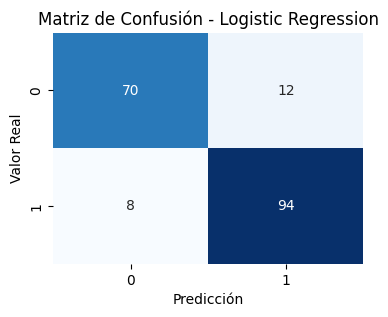

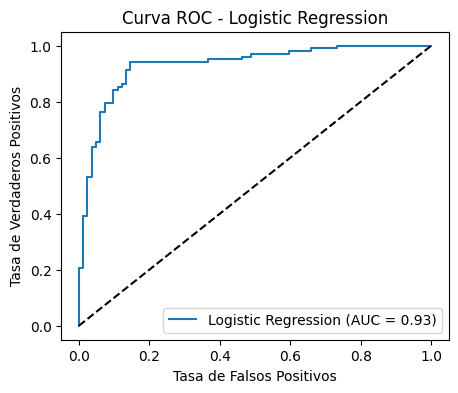

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs", "liblinear"]
}

result_lr = train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    model=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    model_name="Logistic Regression"
)


El conjunto de resultados para el modelo de **Regresión Logística** indica un **rendimiento excelente y robusto**, logrando una **Accuracy de 0.8913** y un sobresaliente **AUC de 0.9304** lo que confirma su **gran capacidad para distinguir entre las clases**. La matriz de confusión  muestra un número bajo de errores con solo **8 Falsos Negativos** (casos 1 mal clasificados como 0) y **12 Falsos Positivos** (casos 0 mal clasificados como 1). El reporte de clasificación destaca que el modelo tiene una alta eficacia en la predicción de la clase **'True'** (clase 1), alcanzando un **Recall de 0.9216** (identificando más del 92% de los casos positivos reales), mientras que la clase **'False'** (clase 0) presenta una **Precisión de 0.8974**. En resumen, este modelo de Regresión Logística es un **predictor altamente efectivo y confiable**.

### **3.2. RandomForestClassifier:**

🔹 Random Forest
Mejores parámetros encontrados: {'clf__bootstrap': False, 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
AUC (validación cruzada): 0.9252
AUC (test): 0.9206
Accuracy (test): 0.8587

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8333    0.8537    0.8434        82
        True     0.8800    0.8627    0.8713       102

    accuracy                         0.8587       184
   macro avg     0.8567    0.8582    0.8573       184
weighted avg     0.8592    0.8587    0.8588       184



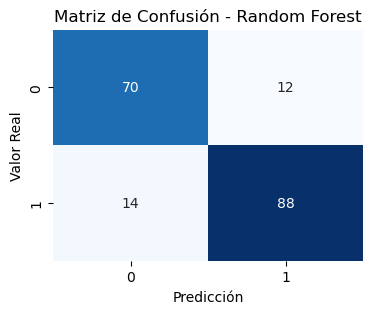

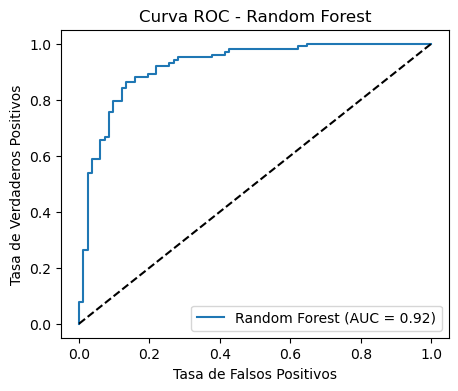

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Definimos el espacio de hiperparámetros a explorar
param_grid_rf = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__bootstrap": [True, False]
}

# Entrenamos y evaluamos el modelo
result_rf = train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    model=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    model_name="Random Forest"
)


El conjunto de resultados para el modelo de **Random Forest** indica un **rendimiento muy sólido**, logrando una **Accuracy de 0.8587** y un excelente **AUC de 0.9206**, lo que confirma su **gran capacidad de discriminación** entre las clases, ubicándose cerca del rendimiento superior del modelo de Regresión Logística. La matriz de confusión  muestra un buen balance en los errores, con **14 Falsos Negativos** (casos 1 mal clasificados como 0) y **12 Falsos Positivos** (casos 0 mal clasificados como 1). El reporte de clasificación destaca que el modelo mantiene una alta eficacia para ambas clases, con la clase **'True'** (clase 1) alcanzando una **Precisión de 0.8800** y la clase **'False'** (clase 0) un **Recall de 0.8537**. En resumen, este modelo de *Random Forest* es un **predictor altamente efectivo y confiable**.

### **3.3. K-Nearest Neighbors:**

🔹 K-Nearest Neighbors
Mejores parámetros encontrados: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform'}
AUC (validación cruzada): 0.9043
AUC (test): 0.9142
Accuracy (test): 0.8696

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8718    0.8293    0.8500        82
        True     0.8679    0.9020    0.8846       102

    accuracy                         0.8696       184
   macro avg     0.8699    0.8656    0.8673       184
weighted avg     0.8696    0.8696    0.8692       184



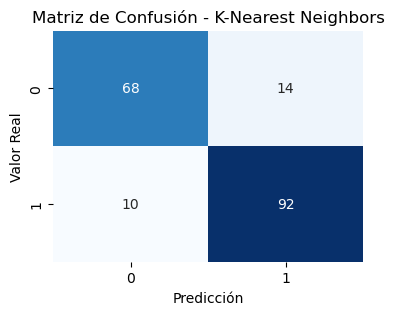

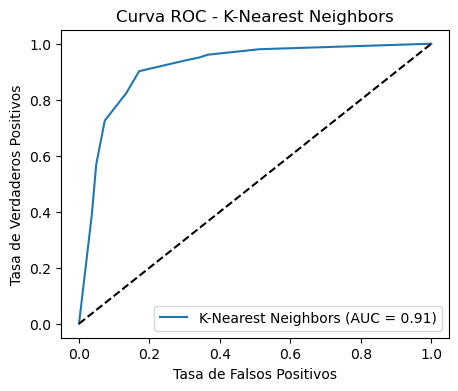

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Espacio de hiperparámetros para KNN
param_grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # 1 = Manhattan, 2 = Euclidiana
}

# Entrenamiento y evaluación
result_knn = train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    model=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    model_name="K-Nearest Neighbors"
)


El conjunto de resultados para el modelo **K-Nearest Neighbors (KNN)** demuestra un **rendimiento muy sólido**, logrando una **Accuracy de 0.8696** y un excelente **AUC de 0.9142**, lo que confirma su **gran capacidad de discriminación**. La matriz de confusión  presenta un bajo número de errores, con solo **10 Falsos Negativos** (casos 1 mal clasificados como 0) y **14 Falsos Positivos** (casos 0 mal clasificados como 1). El reporte de clasificación indica una ligera ventaja en la predicción de la clase **'True'** (clase 1), alcanzando un **Recall de 0.9020** (identificando más del 90% de los casos positivos reales), mientras que la clase **'False'** (clase 0) presenta una **Precisión de 0.8718**. En resumen, este modelo KNN es un **predictor altamente efectivo y confiable**, ofrece un rendimiento competitivo que lo consolida como una excelente opción.

### **3.4. Gradient Boosting Classifier:**

🔹 Gradient Boosting
Mejores parámetros encontrados: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
AUC (validación cruzada): 0.9249
AUC (test): 0.9280
Accuracy (test): 0.8641

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8434    0.8537    0.8485        82
        True     0.8812    0.8725    0.8768       102

    accuracy                         0.8641       184
   macro avg     0.8623    0.8631    0.8627       184
weighted avg     0.8643    0.8641    0.8642       184



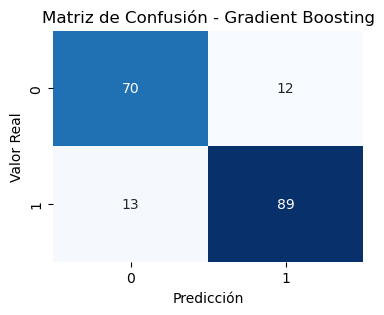

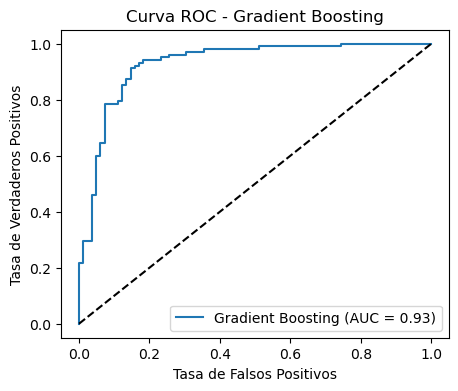

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Espacio de hiperparámetros para Gradient Boosting
param_grid_gb = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [0.8, 1.0]
}

# Entrenamiento y evaluación
result_gb = train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    model=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    model_name="Gradient Boosting"
)


El conjunto de resultados para el modelo **Gradient Boosting** indica un **rendimiento excelente y robusto**, logrando una **Accuracy de 0.8641** y un sobresaliente **AUC de 0.9280**. Este *AUC* lo posiciona como el segundo mejor modelo validado, muy cerca del modelo de Regresión Logística, confirmando su **gran capacidad para distinguir entre las clases**. La matriz de confusión  muestra un bajo número de errores, con **13 Falsos Negativos** (casos 1 mal clasificados como 0) y **12 Falsos Positivos** (casos 0 mal clasificados como 1). El reporte de clasificación destaca que el modelo mantiene una alta eficacia en la predicción de ambas clases, con la clase **'True'** (clase 1) alcanzando una **Precisión de 0.8812** y la clase **'False'** (clase 0) un **Recall de 0.8537**. En resumen, este modelo de *Gradient Boosting* es un **predictor altamente efectivo y confiable**.

## **4. Comparación de los Modelos:**

###  **Comparación Final de Modelos Válidos**

| Clasificación | Modelo | AUC (Test) | Accuracy (Test) | F1-Score (Promedio Ponderado) |
| :---: | :--- | :---: | :---: | :---: |
| **1 (Mejor)** | **Logistic Regression** | **0.9304** | **0.8913** | **0.8910** |
| 2 | Gradient Boosting | 0.9280 | 0.8641 | 0.8642 |
| 3 | Random Forest | 0.9206 | 0.8587 | 0.8588 |
| **4(peor)** | K-Nearest Neighbors | 0.9142 | 0.8696 | 0.8692 |

## **5. Conclusiones:**

### **1. Modelo de Mejor Rendimiento:**



El **Modelo de Regresión Logística**  es el claro **mejor modelo** de clasificación en este conjunto de datos. Logró el valor más alto en todas las métricas clave:
* **AUC (Test) de 0.9304**: Indica la mayor capacidad de discriminación, siendo el mejor para distinguir correctamente entre las clases positivas y negativas en todos los umbrales.
* **Accuracy (Test) de 0.8913**: Clasificó correctamente casi el 90% de las instancias de prueba.
* **F1-Score de 0.8910**: Muestra el mejor equilibrio general entre precisión y *recall*.

### **2. Modelo de Menor Rendimiento:**


El modelo **K-Nearest Neighbors (KNN)** es el que presenta el **AUC más bajo (0.9142)** entre los cuatro finalistas, lo que lo clasifica como el modelo de menor capacidad de discriminación. A pesar de esto, su *Accuracy* de **0.8696** es competitiva (de hecho, es la segunda más alta), lo que sugiere que puede haber clasificado bien las instancias con una alta certeza, pero fue menos capaz de ordenar correctamente las predicciones de probabilidad.